# importing libraries

In [230]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from IPython.display import display
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

# Data preperation

In [231]:
df = pd.read_csv("CreditScoring.csv")
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [232]:
df.columns = df.columns.str.lower()
df.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype='object')

In [233]:
'''
# change factor levels (i.e. categories)
levels(dd$Status) = c("good", "bad")
levels(dd$Home) = c("rent", "owner", "priv", "ignore", "parents", "other")
levels(dd$Marital) = c("single", "married", "widow", "separated", "divorced")
levels(dd$Records) = c("no_rec", "yes_rec")
levels(dd$Job) = c("fixed", "partime", "freelance", "others")

'''

'\n# change factor levels (i.e. categories)\nlevels(dd$Status) = c("good", "bad")\nlevels(dd$Home) = c("rent", "owner", "priv", "ignore", "parents", "other")\nlevels(dd$Marital) = c("single", "married", "widow", "separated", "divorced")\nlevels(dd$Records) = c("no_rec", "yes_rec")\nlevels(dd$Job) = c("fixed", "partime", "freelance", "others")\n\n'

In [234]:
status_values  = {
    1: "ok",
    2: "default",
    0: "unk"
}

df.status =  df.status.map(status_values)

In [235]:
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [236]:
home_values = {
    1: "rent", 
    2: "owner",
    3: "private", 
    4: "ignore",
    5: "parents", 
    6: "other",
    0: "unk"
    
}
df.home = df.home.map(home_values)

In [237]:
df.home.value_counts()

owner      2107
rent        973
parents     783
other       319
private     247
ignore       20
unk           6
Name: home, dtype: int64

In [238]:
marital_values  = {    
    1: "single", 
    2:"married", 
    3:"widow", 
    4:"separated", 
    5:"divorced",
    0: "unk"
}

df.marital = df.marital.map(marital_values)

In [239]:
df.marital.value_counts()

married      3241
single        978
separated     130
widow          67
divorced       38
unk             1
Name: marital, dtype: int64

In [240]:
df.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype='object')

In [241]:
record_values = {
    1: "no",
    2:"yes",
    0: "unk"
}
df.records = df.records.map(record_values)

In [242]:
df.records.value_counts()

no     3682
yes     773
Name: records, dtype: int64

In [243]:
job_values = {
    1: "fixed", 
    2:"partime", 
    3:"freelance", 
    4:"others",
    0: "unk"
}

df.job = df.job.map(job_values)

In [244]:
df.job.value_counts()

fixed        2806
freelance    1024
partime       452
others        171
unk             2
Name: job, dtype: int64

In [245]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [246]:
df.describe().round()
# max values of income, assets, debt 
# are large 99999999.0, which means that this number is missing.

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [247]:
# replacing 99999999.0 into nan values
for c in  ["income", "assets", "debt"]:
    df[c] = df[c].replace(to_replace = 99999999.0, value = np.nan )
    

In [248]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [249]:
df = df[df.status != "unk"].reset_index(drop= True)

# Splitting the data into traing, testing sets

In [250]:
df_full_train, df_test = train_test_split(df,test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train,test_size=0.25, random_state=11)

In [251]:
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

In [252]:
df_train.status.value_counts()

ok         1940
default     732
Name: status, dtype: int64

In [253]:
y_train = (df_train.status == "default").astype(int).values
y_val = (df_val.status == "default").astype(int).values
y_test = (df_test.status == "default").astype(int).values

In [254]:
del df_train['status']
del df_val['status']
del df_test['status']

In [255]:
df_train 

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


# Decision trees

How a decision tree looks like

Training a decision tree

Overfitting

Controlling the size of the tree


In [256]:
def assess_risk(client):
    if client['records'] == "yes":
        if client["job"] == "parttime":
            return "default"
        else:
            return "ok"
    else:
        if client['assets'] > 6000:
            return "ok"
        else:
            return "default"

In [257]:
xi = df_train.iloc[0].to_dict()

In [258]:
assess_risk(xi)

'ok'

In [259]:
train_dicts = df_train.fillna(0).to_dict(orient = "records")
dv=  DictVectorizer(sparse = False)

In [260]:
X_train = dv.fit_transform(train_dicts)

In [261]:
dv.get_feature_names()

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

In [262]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [263]:
val_dicts  = df_val.fillna(0).to_dict(orient = "records")
X_val = dv.transform(val_dicts) 

In [264]:
y_pred = dt.predict_proba(X_val)[:, 1]
#y_pred

In [265]:
roc_auc_score(y_val, y_pred)

0.6650117459010438

In [266]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [267]:
# to avoid overfittin let's  defie the max_dept =3
dt = DecisionTreeClassifier(max_depth =3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [268]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc= roc_auc_score(y_train, y_pred)
print("train: ", auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc= roc_auc_score(y_val, y_pred)
print("val: ", auc)

train:  0.7761016984958594
val:  0.7389079944782155


In [269]:
print(export_text(dt, feature_names = dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Decision tree learning algorithm 

In [270]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]
df_example = pd.DataFrame(data, columns = ["assets", 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [271]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [272]:
Ts = [0, 2000,3000,4000,5000,8000]

In [273]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize = True))
    display(df_right)
    print(df_right.status.value_counts(normalize = True))
    print()

0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



In [274]:
data_3 = [
    [8000, 3000,  'default'],
    [2000, 1000, 'default'],
    [0, 1000, 'default'],
    [5000, 1000,  'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000, 500, 'ok'],
    [3000, 2000,  'default'],
]
df_example_3 = pd.DataFrame(data_3, columns = ["assets","debt" ,"status"])
df_example_3

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [275]:
df_example_3.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [276]:
thresholds = {
    "assets" : [0, 2000,3000,4000,5000,8000],
     "debt" : [ 500, 1000, 2000]
}

for feature, Ts in thresholds.items():
    print("#####################")
    print(feature)
    df_left = df_example_3[df_example_3[feature] <= T]
    df_right = df_example_3[df_example_3[feature] > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize = True))
    display(df_right)
    print(df_right.status.value_counts(normalize = True))
    print()
print("######################")



#####################
assets


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

#####################
debt


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status


Series([], Name: status, dtype: float64)

######################


# Decision Tree Parametet Tuning

select max-dept

select min_samples_leaf

In [277]:
for d in [1,2,3,4,5,6,10,15,20, None]:
    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.754
  10 -> 0.706
  15 -> 0.676
  20 -> 0.665
None -> 0.656


In [278]:
scores = []
for d in [4,5,6,7,10,15,20,None]:
    for s in [1,2,5,10,15,20,100,200,500]:
        dt = DecisionTreeClassifier(max_depth = d, min_samples_leaf = s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d,s,auc))
    
         

In [279]:
cols  = ["max_depth", "min_samples_leaf", "auc" ]
df_scores = pd.DataFrame(scores, columns  = cols)
df_scores.sort_values(by= "auc", ascending = False)

,max_depth,min_samples_leaf,auc
40,10.0,15,0.790805
49,15.0,15,0.788547
67,NaN,15,0.787762
58,20.0,15,0.786975
22,6.0,15,0.785471
...,...,...,...
71,NaN,500,0.679842
55,20.0,2,0.677790
45,15.0,1,0.668738
63,NaN,1,0.658334


In [280]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf',
                columns=["max_depth"],
                values=['auc'])

df_scores_pivot.round(3) 

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.658  0.761  0.766  0.749  0.741  0.701  0.669  0.657
2                 0.695  0.761  0.767  0.767  0.751  0.727  0.682  0.678
5                 0.713  0.761  0.768  0.762  0.756  0.722  0.713  0.713
10                0.762  0.761  0.762  0.778  0.765  0.768  0.763  0.763
15                0.788  0.764  0.772  0.785  0.780  0.791  0.789  0.787
20                0.781  0.761  0.774  0.774  0.779  0.783  0.780  0.781
100               0.779  0.756  0.763  0.776  0.780  0.779  0.780  0.780
200               0.768  0.747  0.759  0.768  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

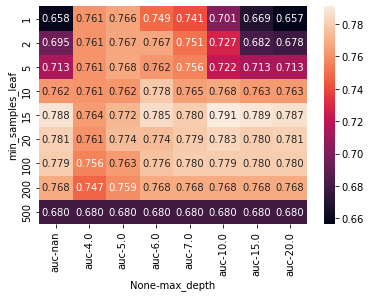

In [281]:
sns.heatmap(df_scores_pivot, annot = True, fmt = '.3f')

In [282]:
# using best parameters
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

# Ensembles and Random Forest

In [283]:
rf = RandomForestClassifier(n_estimators= 10, random_state  = 1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [284]:
y_pred = rf.predict_proba(X_val)[:,1]

In [285]:
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [286]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

In [287]:
scores  = []
for n in range(10,201,10):
    rf = RandomForestClassifier(n_estimators= n, random_state  = 1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [288]:
df_scores = pd.DataFrame(scores, columns = ["n_estimators", "auc"])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


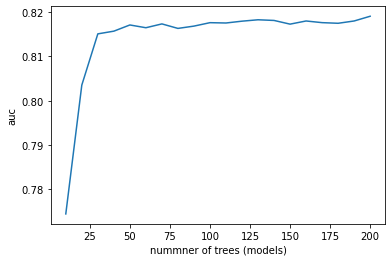

In [289]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel("number of trees (models)")
plt.ylabel('auc')
plt.show()

In [290]:
scores  = []
for d in [5,10,15]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators= n,
                                    max_depth = d,
                                    random_state  = 1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [291]:
cols  =  ["max_depth", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns =cols )
df_scores

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878
5,5,60,0.801167
6,5,70,0.802251
7,5,80,0.803244
8,5,90,0.803616
9,5,100,0.804452


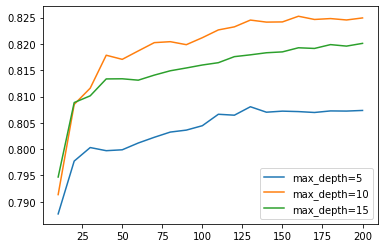

In [292]:
for d in[5,10,15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc,
            label = 'max_depth=%d' % d)
plt.legend()

In [293]:
max_depth = 10

In [294]:
scores = []
for s in [1,3, 5,10,50]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators= n,
                                    max_depth = max_depth,
                                    min_samples_leaf = s,
                                    random_state  = 1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [295]:
cols  =  ["min_samples_leaf", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns =cols )
df_scores

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058
...,...,...,...
95,50,160,0.805929
96,50,170,0.805172
97,50,180,0.805324
98,50,190,0.805596


In [296]:
colors = ["black","blue", "orange","red","grey"]
min_samples_leaf = [1,3,5,10,50]
zip(min_samples_leaf, colors) # <zip at 0x23bc69fbdc0> 
# to show the values
list(zip(min_samples_leaf, colors) )

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (50, 'grey')]

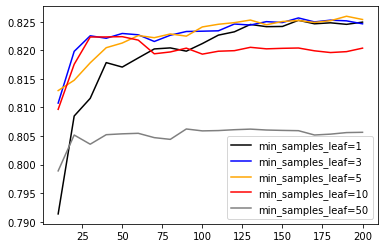

In [297]:

for s, col in zip(min_samples_leaf, colors):
    df_subset = df_scores[df_scores.min_samples_leaf  == s]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color = col,
            label = 'min_samples_leaf=%d' % s)
plt.legend()

In [298]:
mean_samples_leaf = 3

In [299]:
# the final model with best parameters
rf = RandomForestClassifier(n_estimators= 100,
                                    max_depth = max_depth,
                                    min_samples_leaf = mean_samples_leaf,
                                    random_state  = 1,
                                    n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_jobs=-1,
                       random_state=1)

# Gradient Boosting and XGBoost

In [300]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [301]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 2,
}

model  = xgb.train(xgb_params, dtrain, num_boost_round = 200)

[20:08:14] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[20:08:14] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[20:08:14] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[20:08:14] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[20:08:14] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d

[20:08:15] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[20:08:15] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[20:08:15] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[20:08:15] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[20:08:15] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[20:08:15] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[20:08:15] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[20:08:15] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[20:08:15] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[20:08:15] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[20:08:16] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[20:08:16] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[20:08:16] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[20:08:16] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[20:08:16] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

[20:08:16] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[20:08:16] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[20:08:16] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[20:08:16] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6


In [302]:
y_pred  = model.predict(dval)
y_pred

array([3.95534746e-02, 2.13190774e-03, 4.60552843e-03, 1.68832675e-01,
       3.01061780e-04, 1.30593812e-03, 2.36471504e-04, 6.72035635e-01,
       4.50287908e-01, 7.82015850e-05, 3.88970524e-02, 9.97273266e-01,
       5.37740111e-01, 7.35800364e-04, 4.04056581e-03, 9.60047483e-01,
       4.43820260e-04, 5.44882655e-01, 2.79813400e-03, 7.73551613e-02,
       1.85864349e-03, 1.41037256e-01, 3.98235163e-03, 9.06265795e-01,
       8.58502209e-01, 4.96800989e-03, 8.63798201e-01, 4.12434600e-02,
       9.16178286e-01, 9.13706244e-05, 9.97725070e-01, 3.42956334e-01,
       2.66283881e-02, 8.93705487e-02, 1.45540675e-04, 2.03616692e-05,
       9.99607384e-01, 2.59687871e-01, 8.99421751e-01, 8.69022191e-01,
       2.41115764e-02, 9.76342380e-01, 1.16770891e-02, 6.53584719e-01,
       4.84928933e-05, 4.12175839e-04, 4.47582304e-01, 2.21406459e-04,
       2.80490518e-02, 6.38221251e-03, 1.28188723e-04, 2.73735300e-02,
       4.69494233e-04, 2.57968247e-01, 8.24921846e-01, 5.86968996e-02,
      

In [303]:
roc_auc_score(y_val, y_pred)

0.8003166549611296

In [304]:
#y_val

In [305]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [327]:
scores ={}

In [365]:
%%capture output

xgb_params = {
    'eta': 1.0,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}


model  = xgb.train(xgb_params, dtrain,
                   num_boost_round = 200,
                   verbose_eval  = 5,
                  evals = watchlist)
model

In [366]:
s = output.stdout
line = s.split("\n")[0] 
num_iter, train_auc, val_auc = line.split('\t')
print(int(num_iter.strip('[]')))
print(float(train_auc.split(':')[1]))
print(float(val_auc.split(':')[1]) )

0
0.863
0.76818


In [367]:
def parse_xgb_output(output):
    results = []
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line =  line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val  = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns = columns)
    return df_results

In [368]:
df_scores  = parse_xgb_output(output)

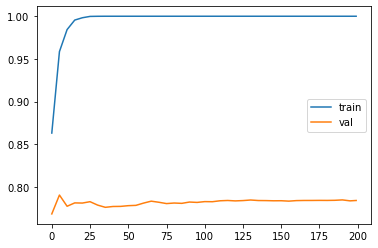

In [369]:
plt.plot(df_scores.num_iter, df_scores.train_auc, label = 'train')
plt.plot(df_scores.num_iter, df_scores.val_auc, label = 'val')
plt.legend()

# XGBoost parameter tuning

In [370]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [371]:
#scores

In [372]:
# key = 'eta=0.3', value is output
scores['eta=0.1']

,num_iter,train_auc,val_auc
0,0,0.86300,0.76818
1,5,0.89688,0.79855
2,10,0.91558,0.80009
3,15,0.93019,0.80707
4,20,0.93933,0.80920
5,25,0.94793,0.81202
6,30,0.95411,0.81557
7,35,0.95900,0.81599
8,40,0.96332,0.81843
9,45,0.96755,0.82226


In [373]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.3', 'eta=0.1', 'eta=0.05', 'eta=1.0'])

In [374]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1.0'

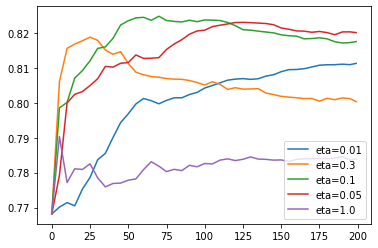

In [376]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label = key)
plt.legend()

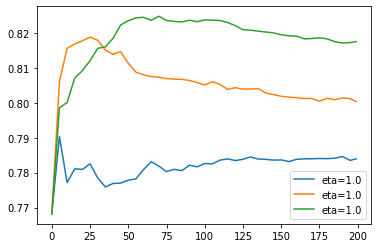

In [377]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label = key)
plt.legend()

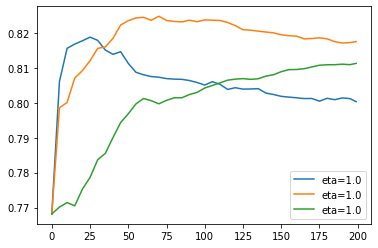

In [378]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label = key)
plt.legend()

## tuning max_depth

In [379]:
scores ={}

In [422]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}


model  = xgb.train(xgb_params, dtrain,
                   num_boost_round = 200,
                   verbose_eval  = 5,
                  evals = watchlist)
model

In [424]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [425]:
df_scores  = parse_xgb_output(output)

In [428]:
#del scores[ 'max_depth=10']

In [429]:
scores.keys()

dict_keys(['max_depth=6', 'max_depth=3', 'max_depth=4'])

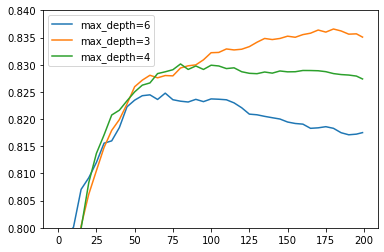

In [431]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label = max_depth)
plt.ylim(0.8, 0.84)
plt.legend()
    

In [ ]:
 # the bestt max_depth is 3

## tuning the 'min_child_weight'

In [433]:
scores ={}

In [444]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}


model  = xgb.train(xgb_params, dtrain,
                   num_boost_round = 200,
                   verbose_eval  = 5,
                  evals = watchlist)
model

In [445]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

In [446]:
df_scores  = parse_xgb_output(output)

In [447]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

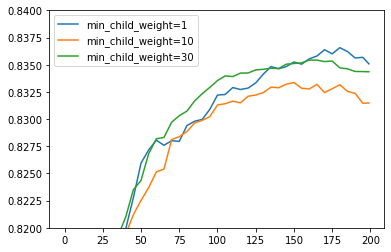

In [449]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label = min_child_weight)

plt.ylim(0.82,0.84)
plt.legend()

In [450]:
# min_child_weight 1 is ok, with 175 iterations
# the final xgb model
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model  = xgb.train(xgb_params, dtrain,
                   num_boost_round = 175)
model


# Comparing decision tree, random forest and xgboost

In [452]:
y_pred  = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7853194400716863

In [453]:
y_pred  = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8233361991717324

In [457]:
y_pred  = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8360387251459157

## using the best model - xgb for the whole traing dataset

In [467]:
df_full_train = df_full_train.reset_index(drop = True)
df_full_train

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,22,owner,48,48,married,no,fixed,60,110.0,3000.0,0.0,1000,1460
1,default,8,other,60,41,married,no,freelance,45,62.0,0.0,0.0,1800,2101
2,ok,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
3,ok,1,owner,12,61,married,no,others,45,103.0,20000.0,0.0,300,650
4,ok,13,owner,60,27,married,no,fixed,35,253.0,7000.0,0.0,1060,1750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3558,default,4,owner,60,47,married,no,freelance,75,0.0,13500.0,0.0,1900,1976
3559,ok,2,rent,60,28,single,no,fixed,45,101.0,0.0,0.0,1300,1333
3560,ok,2,parents,36,25,single,no,fixed,35,110.0,0.0,0.0,500,1200
3561,ok,4,other,60,25,single,no,fixed,35,162.0,0.0,0.0,1800,2999


In [464]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [468]:
del df_full_train['status']

In [473]:
dicts_full_train = df_full_train.to_dict(orient = "records")
dv = DictVectorizer(sparse = False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient = 'records')
X_test = dv.transform(dicts_test)

In [475]:
dfulltrain = xgb.DMatrix(X_full_train, label = y_full_train,
                        feature_names =  dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names = dv.get_feature_names())

In [476]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model  = xgb.train(xgb_params, dtrain,
                   num_boost_round = 175)
model


In [480]:
y_pred = model.predict(dtest)
y_pred[:10]
roc_auc_score(y_test,y_pred)

0.8264381017545573